<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/TS_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tslearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Time Series Clustering

## Data Loading

In [9]:
train_data = pd.read_csv('./data_samples/Simulated_Sales_TimeSeries/train.csv')
test_data = pd.read_csv('./data_samples/Simulated_Sales_TimeSeries/test.csv')

In [20]:
print(train_data.shape)
print(test_data.shape)
split_ratio = test_data.shape[0]/train_data.shape[0]
print(f'As there are {train_data.shape[0]} rows in train data and {test_data.shape[0]} rows in test data, that means the train:test split ratio is {format((1- split_ratio)*100, ".3f")}:{format(split_ratio*100, ".3f")}')


(230090, 4)
(25550, 4)
As there are 230090 rows in train data and 25550 rows in test data, that means the train:test split ratio is 88.896:11.104


## Exploratory Data Analysis
We wants to see how the different columns data looks from the perspective of 2-d line plots along the time y-axis for discovering if there are potential clusterable patterns among store & number of products sold for all products at that store.

In [22]:
# We can see that there is a 'store', a 'product', and a 'number_sold' column. ('Date' is the primary clustering feature,  we can ignore product)
test_data.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [45]:
# let's plot the time series for a single store and all product's at that store (using matplotlib, numpy, and tslearn)
def plot_sales_for_store(store, data):
    store_product_data = data[(data['store'] == store)]
    # now that we have all the store's data, let's aggregate number_sold for all products at that store
    # and return the store_product_data for clustering
    store_product_data = store_product_data.groupby(['Date']).sum()
    store_product_data = store_product_data.drop(columns=['store', 'product'])
    store_product_data = store_product_data.reset_index()
    store_product_data = store_product_data.sort_values(by=['Date'])
    store_product_data.loc[:, ['Date', 'number_sold']].plot(x='Date', y='number_sold', title='total ' + str(store) + ' sales', figsize=(20, 10))
    store_product_data['store'] = [store] * store_product_data.shape[0]
    return store_product_data
    

(23009, 3)


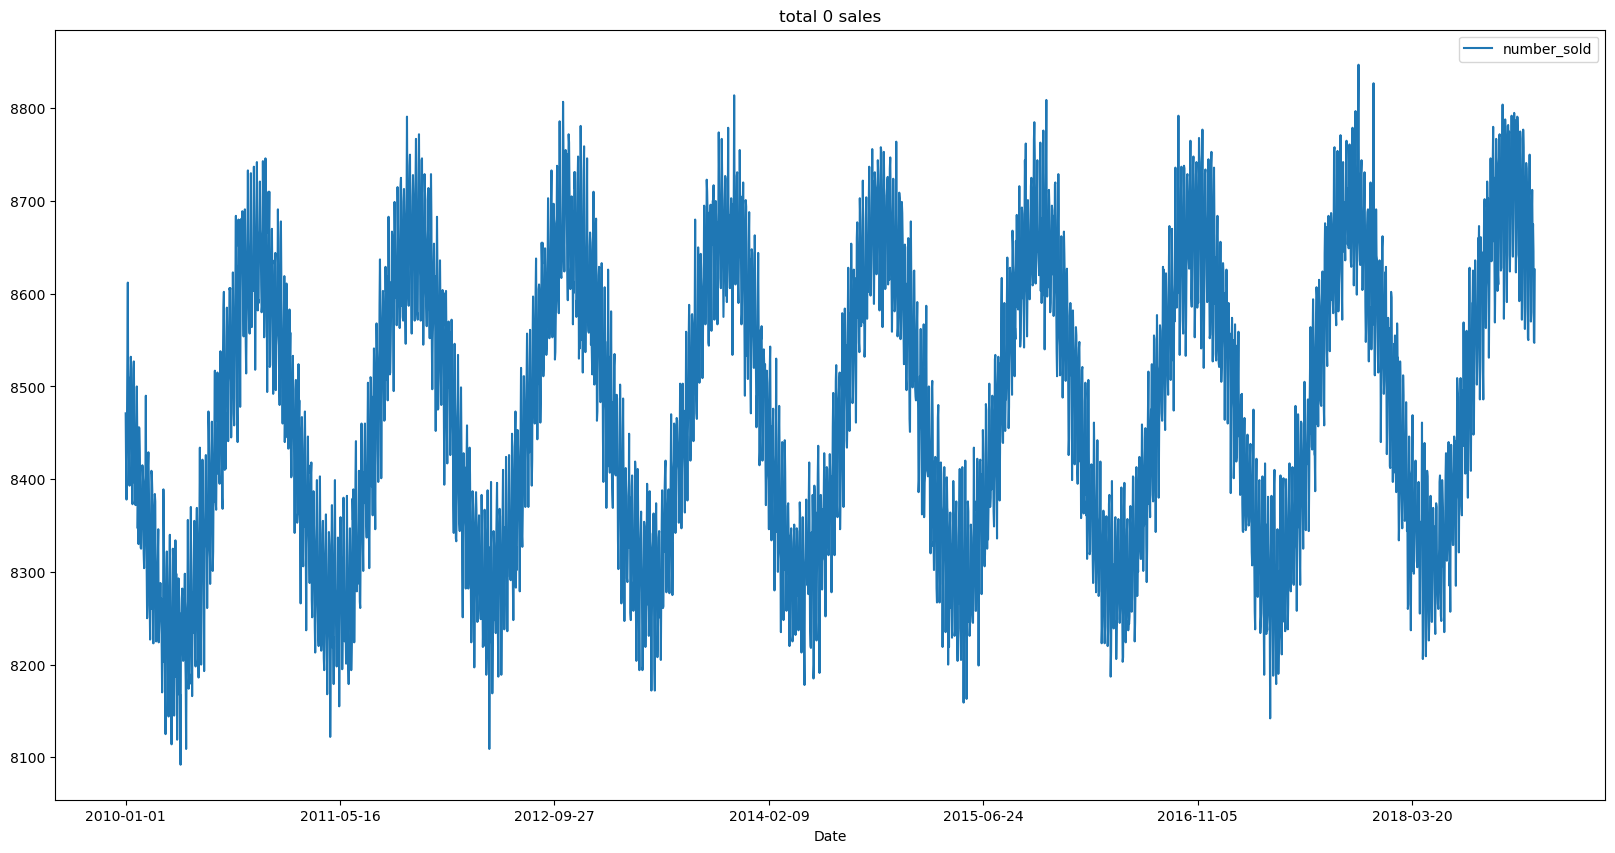

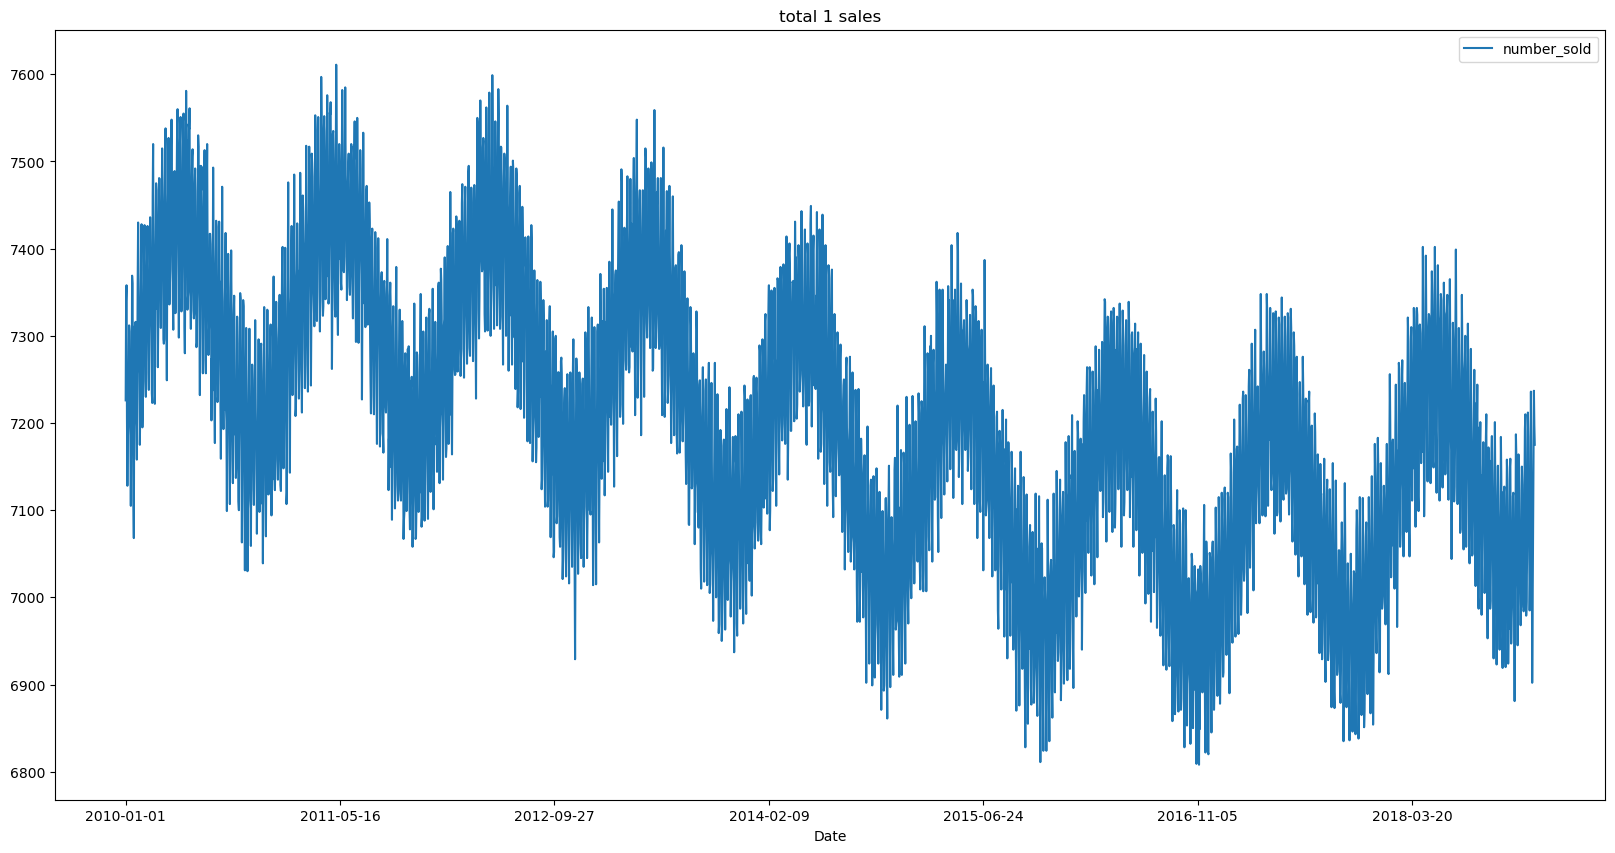

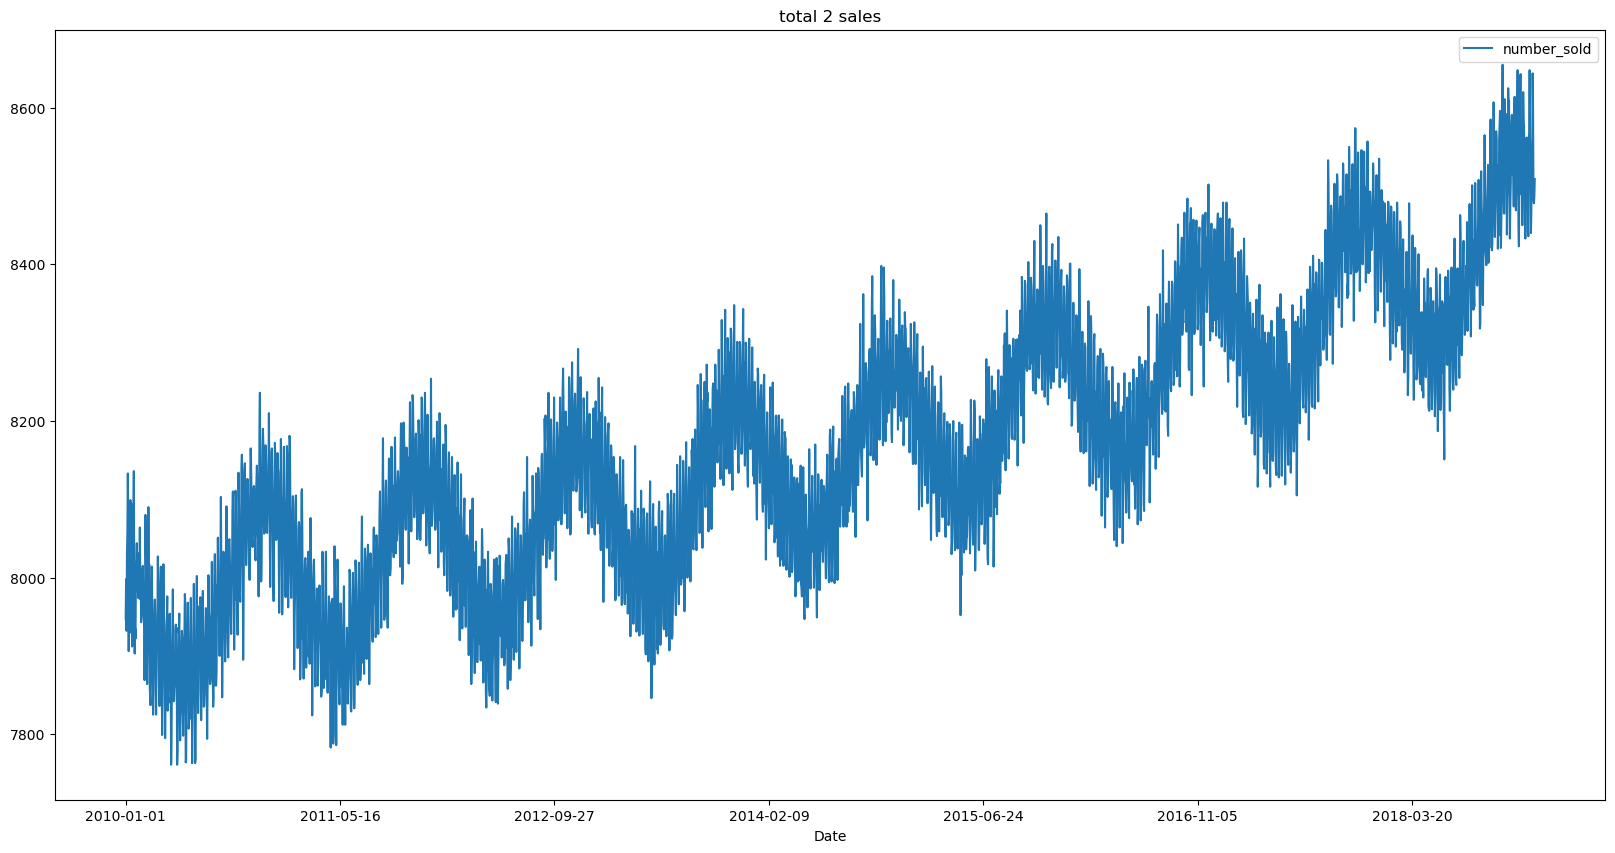

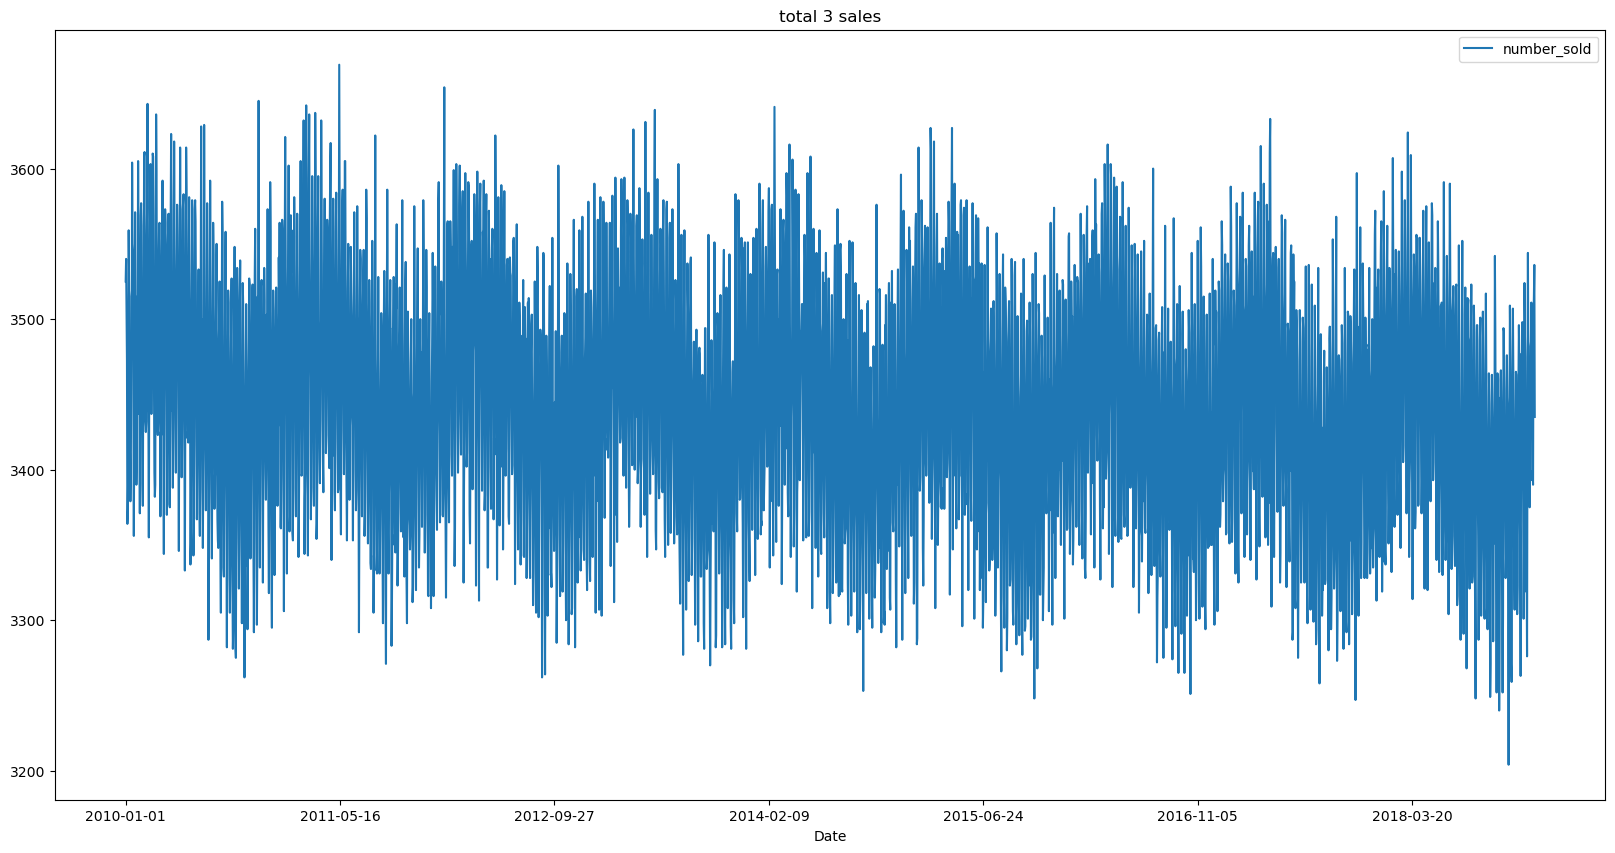

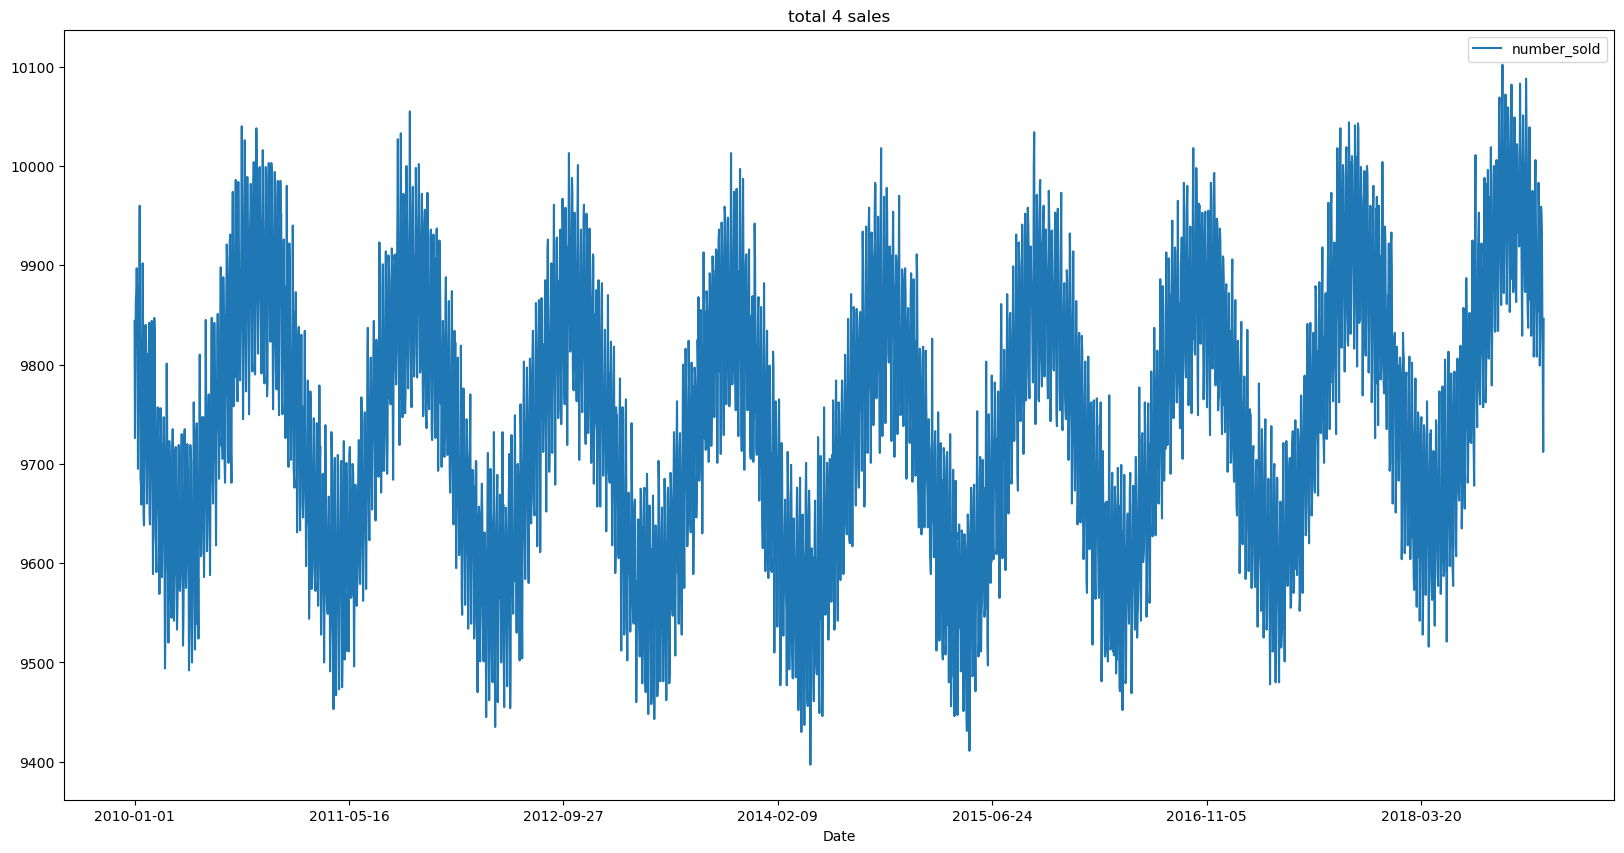

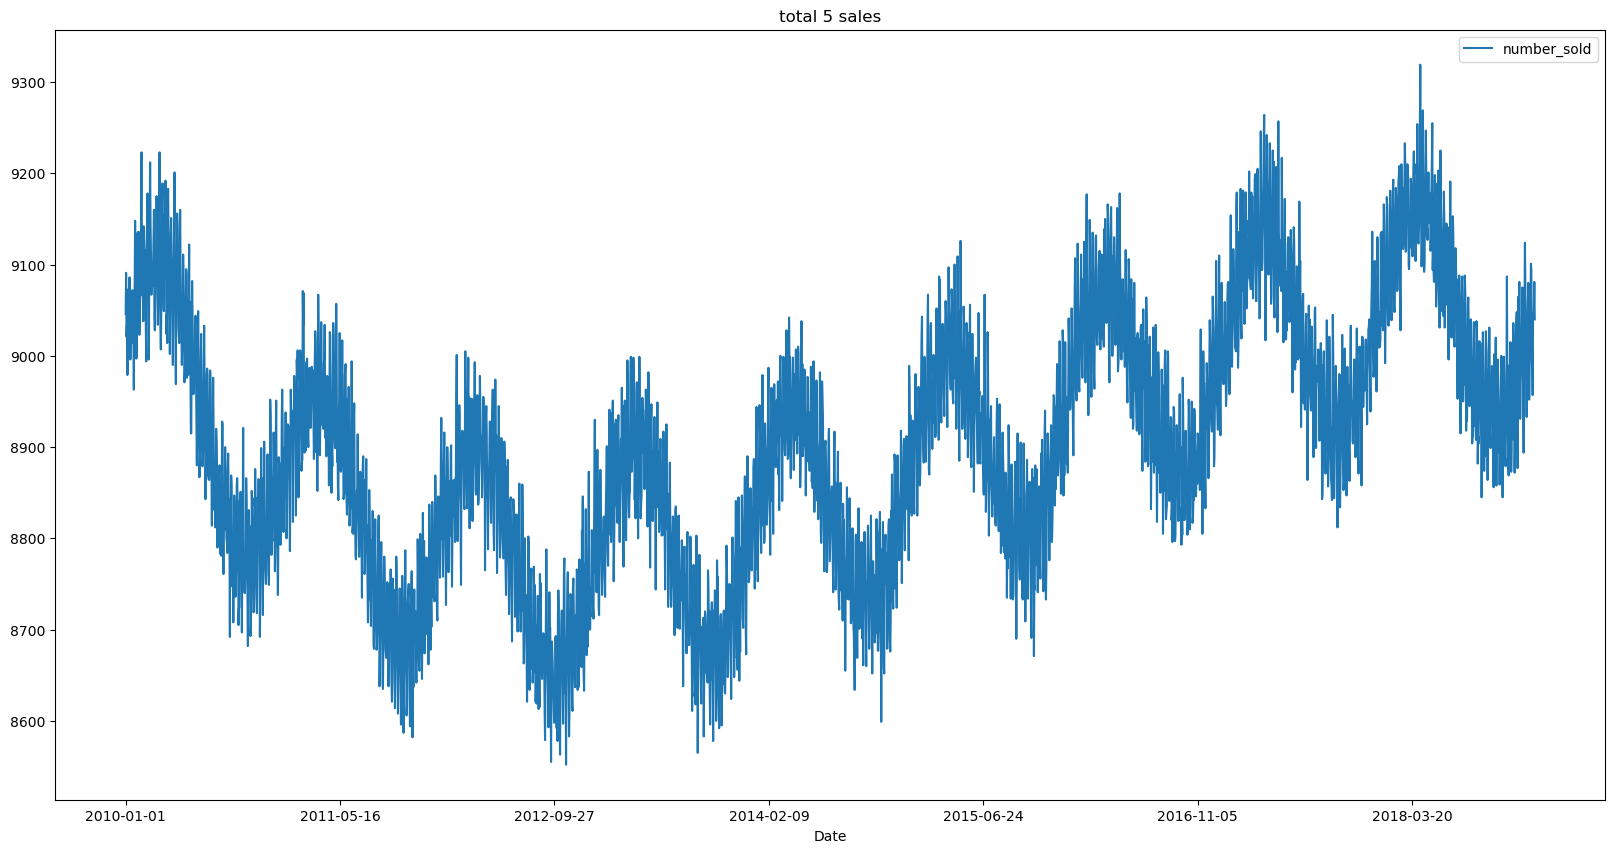

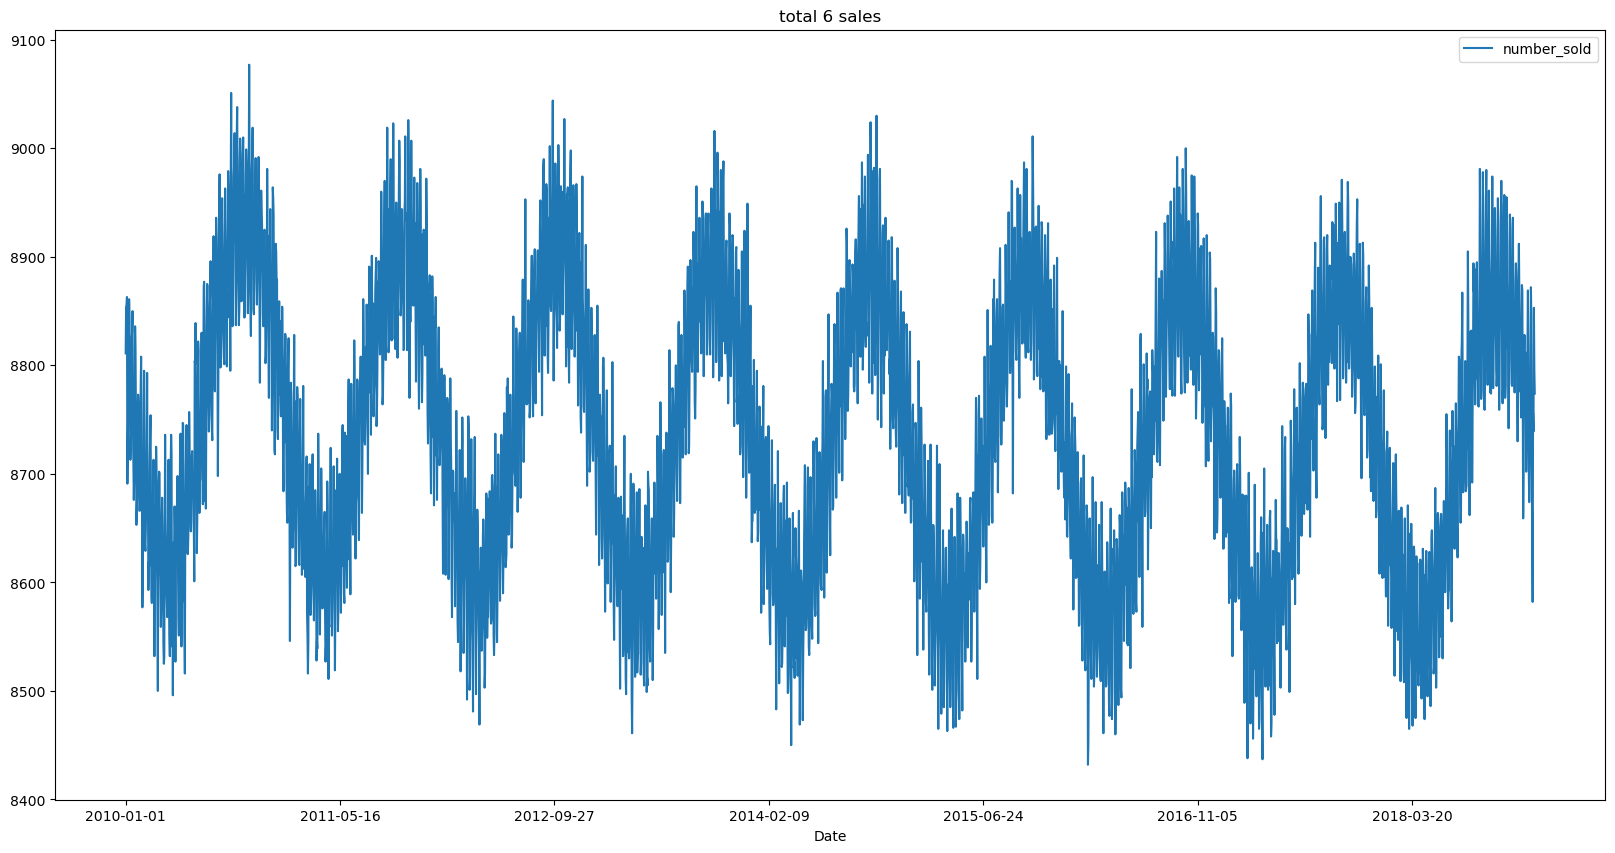

In [46]:
store_product_data_all_stores = None
for store in train_data['store'].unique():
    store_product_data = plot_sales_for_store(store, train_data)
    if store_product_data_all_stores is None:
        store_product_data_all_stores = pd.DataFrame(store_product_data)
    else:
        store_product_data_all_stores = pd.concat([store_product_data_all_stores, pd.DataFrame(store_product_data)])
print(store_product_data_all_stores.shape)


### EDA Insights
We can see that, at first glance, the stores have:

0. Store 0 has Neutral slope, less variation/amplitude, in sales
1. Store 1 has Negative slope, more variation/amplitude in sales
2. Store 2 has Positive slope, less variation/amplitude in sales
3. Store 3 has Negative slope, a LOT of variation/amplitude in sales
4. Store 4 has Neutral slope, more variation/amplitude in sales
5. Store 5 has Neutral slope, less variation/amplitude in sales
6. Store 6 has Negative slope, more variation/amplitude in sales

Let's see if we can apply clustering on the time-series with the tslearn package to identify which stores are similar in sales over time.

## Clustering along Time Series

In [99]:
store_product_data_all_stores.head()

,Date,number_sold,store
0,2010-01-01,8471,0
1,2010-01-02,8411,0
2,2010-01-03,8378,0
3,2010-01-04,8457,0
4,2010-01-05,8541,0


In [82]:
store_product_data_all_stores.describe()

,number_sold,store
count,23009.000000,23009.000000
mean,7809.261072,3.000000
std,1925.204364,2.000043
min,3204.000000,0.000000
25%,7313.000000,1.000000
50%,8489.000000,3.000000
75%,8872.000000,5.000000
max,10102.000000,6.000000


### Feature Engineering

In [104]:
# Now that we have the data in the right format, let's cluster it using tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

# let's scale the numerical data
store_product_data_all_stores_scaled = store_product_data_all_stores.copy()

# use timeseries mean scalar variance to scale the data in store_product_data_all_stores_scaled for number_sold
number_sold_scaled = TimeSeriesScalerMeanVariance(mu=0, std=1).fit_transform(store_product_data_all_stores_scaled.store.values.reshape(1, -1)).reshape(-1)
store_product_data_all_stores_scaled['number_sold'] = number_sold_scaled

In [105]:
# the number_sold column is now scaled across all stores sales. This makes each stores sales comparable to each other
# if we wanted to look and compare products across stores, we would need to scale the number_sold column for each store
store_product_data_all_stores_scaled.describe()

,number_sold,store
count,23009.000000,23009.000000
mean,0.000000,3.000000
std,1.000022,2.000043
min,-1.500000,0.000000
25%,-1.000000,1.000000
50%,0.000000,3.000000
75%,1.000000,5.000000
max,1.500000,6.000000


In [109]:
store_product_data_all_stores_scaled.tail()

,Date,number_sold,store
3282,2018-12-27,1.5,6
3283,2018-12-28,1.5,6
3284,2018-12-29,1.5,6
3285,2018-12-30,1.5,6
3286,2018-12-31,1.5,6


In [110]:
# one-hot encoding the store feature
store_product_data_all_stores_scaled = pd.get_dummies(store_product_data_all_stores_scaled, columns=['store'])
store_product_data_all_stores_scaled.head()

,Date,number_sold,store_0,store_1,store_2,store_3,store_4,store_5,store_6
0,2010-01-01,-1.5,True,False,False,False,False,False,False
1,2010-01-02,-1.5,True,False,False,False,False,False,False
2,2010-01-03,-1.5,True,False,False,False,False,False,False
3,2010-01-04,-1.5,True,False,False,False,False,False,False
4,2010-01-05,-1.5,True,False,False,False,False,False,False


In [111]:
# extracting month and year from date and then dropping date
store_product_data_all_stores_scaled['Date'] = pd.to_datetime(store_product_data_all_stores_scaled['Date'])
store_product_data_all_stores_scaled['month'] = store_product_data_all_stores_scaled['Date'].dt.month
store_product_data_all_stores_scaled['year'] = store_product_data_all_stores_scaled['Date'].dt.year
store_product_data_all_stores_scaled = store_product_data_all_stores_scaled.drop(columns=['Date'])
store_product_data_all_stores_scaled.head()

,number_sold,store_0,store_1,store_2,store_3,store_4,store_5,store_6,month,year
0,-1.5,True,False,False,False,False,False,False,1,2010
1,-1.5,True,False,False,False,False,False,False,1,2010
2,-1.5,True,False,False,False,False,False,False,1,2010
3,-1.5,True,False,False,False,False,False,False,1,2010
4,-1.5,True,False,False,False,False,False,False,1,2010


### Visualization of K-Means Clusters Time-Series Data using TsLearn

In [115]:
# the data is now ready for clustering
# let's try clustering the data using kmeans
# let's try 3 clusters
# we will use the euclidean distance metric
# we will use the kmeans++ initialization method
# we will use 100 iterations

tslearn_kmeans = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=100, random_state=0, n_init=1, init='k-means++')
time_clusters = tslearn_kmeans.fit(store_product_data_all_stores_scaled)
centroids = time_clusters.cluster_centers_

In [122]:
store_product_data_all_stores['cluster'] = time_clusters.labels_
store_product_data_all_stores.head()

,Date,number_sold,store,cluster
0,2010-01-01,8471,0,1
1,2010-01-02,8411,0,1
2,2010-01-03,8378,0,1
3,2010-01-04,8457,0,1
4,2010-01-05,8541,0,1


In [124]:
store_product_data_all_stores.iloc[:, ['date', 'number_sold']]

,number_sold,store
0,8471,0
1,8411,0
2,8378,0
3,8457,0
4,8541,0
...,...,...
3282,8756,6
3283,8739,6
3284,8853,6
3285,8796,6


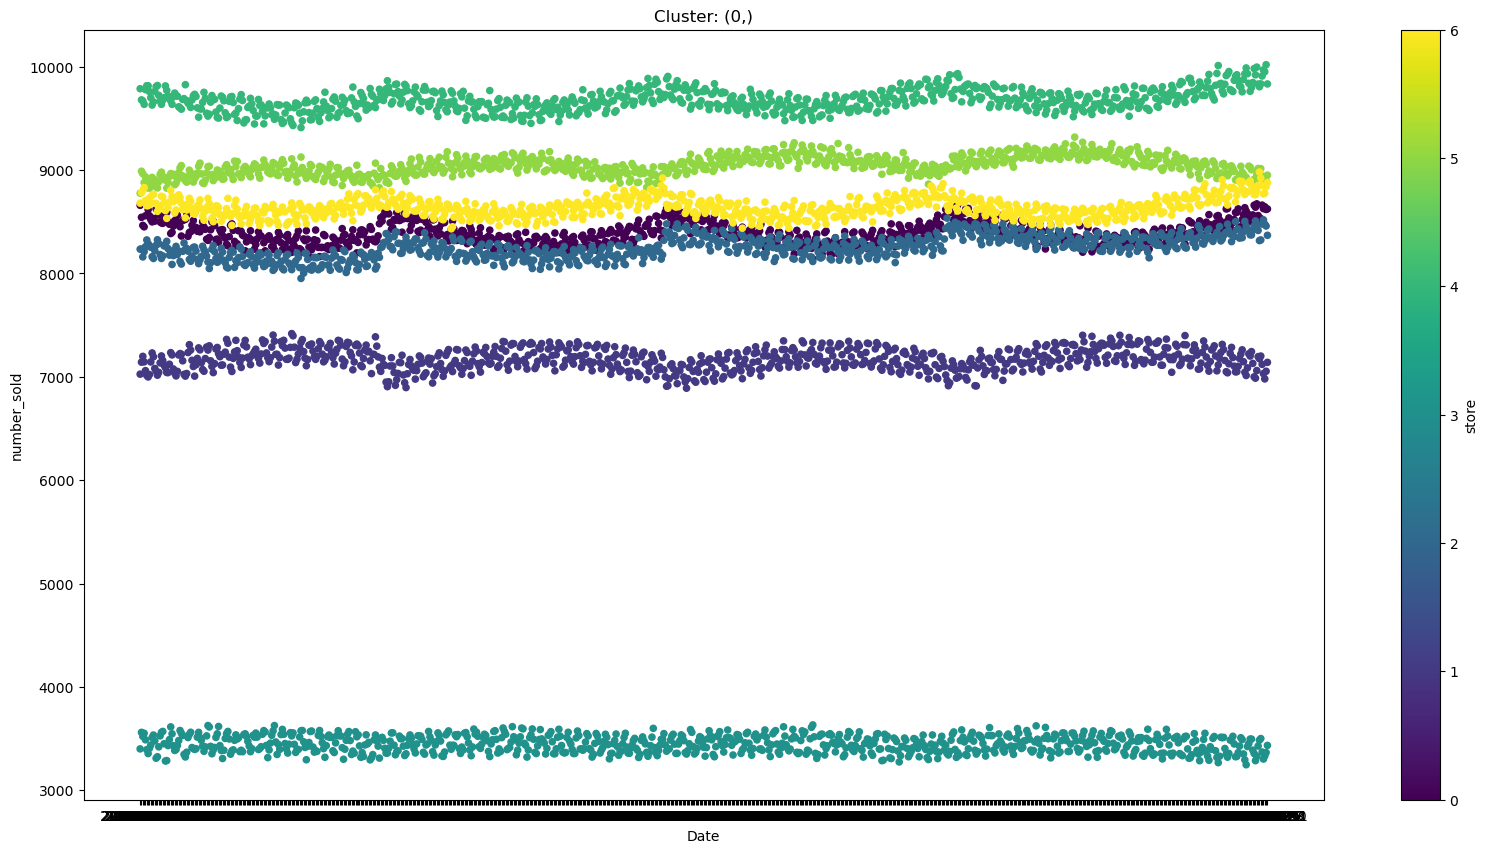

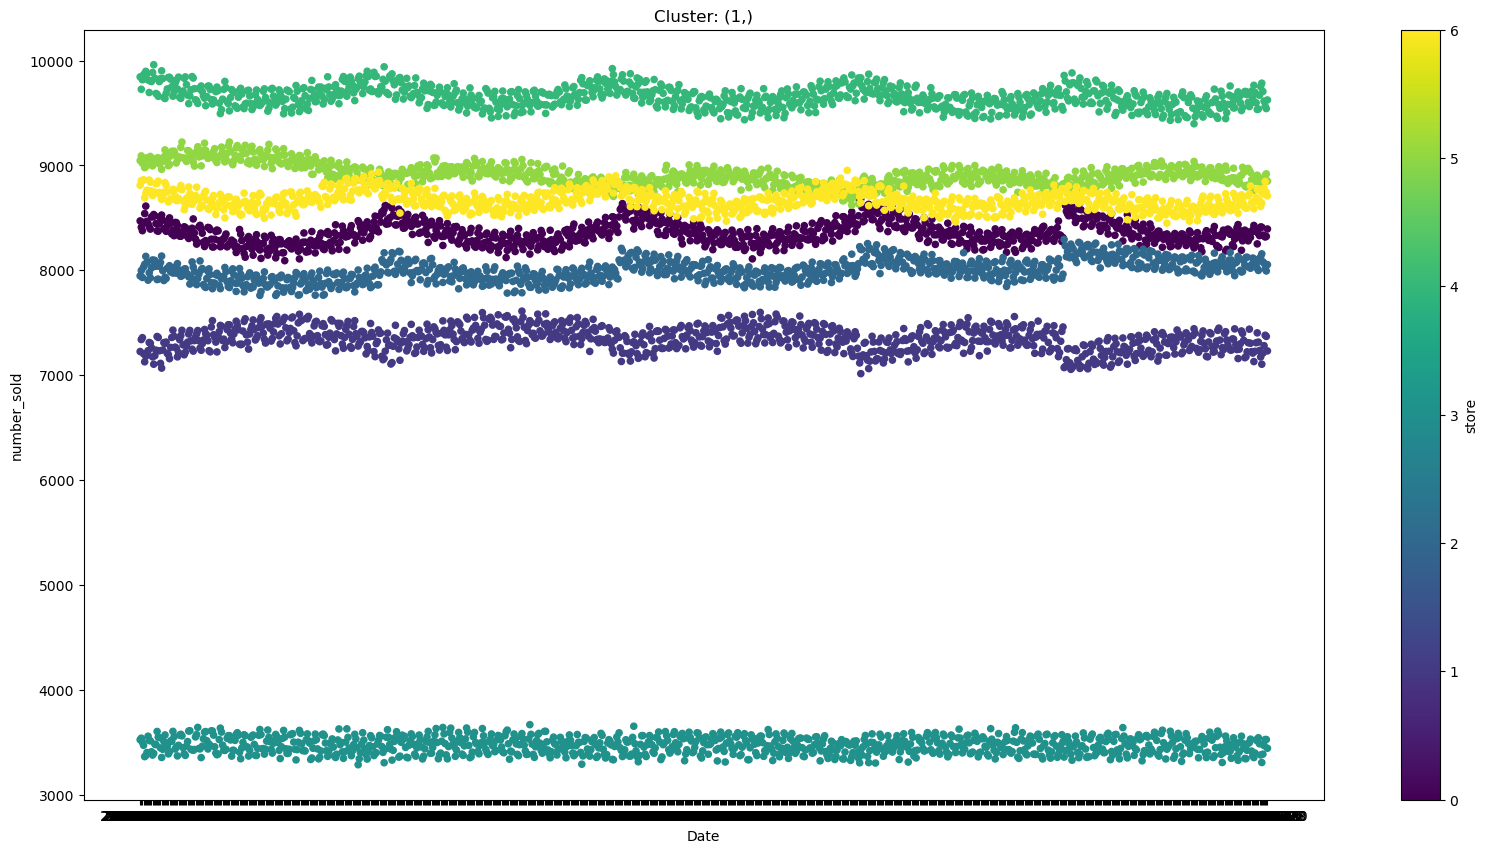

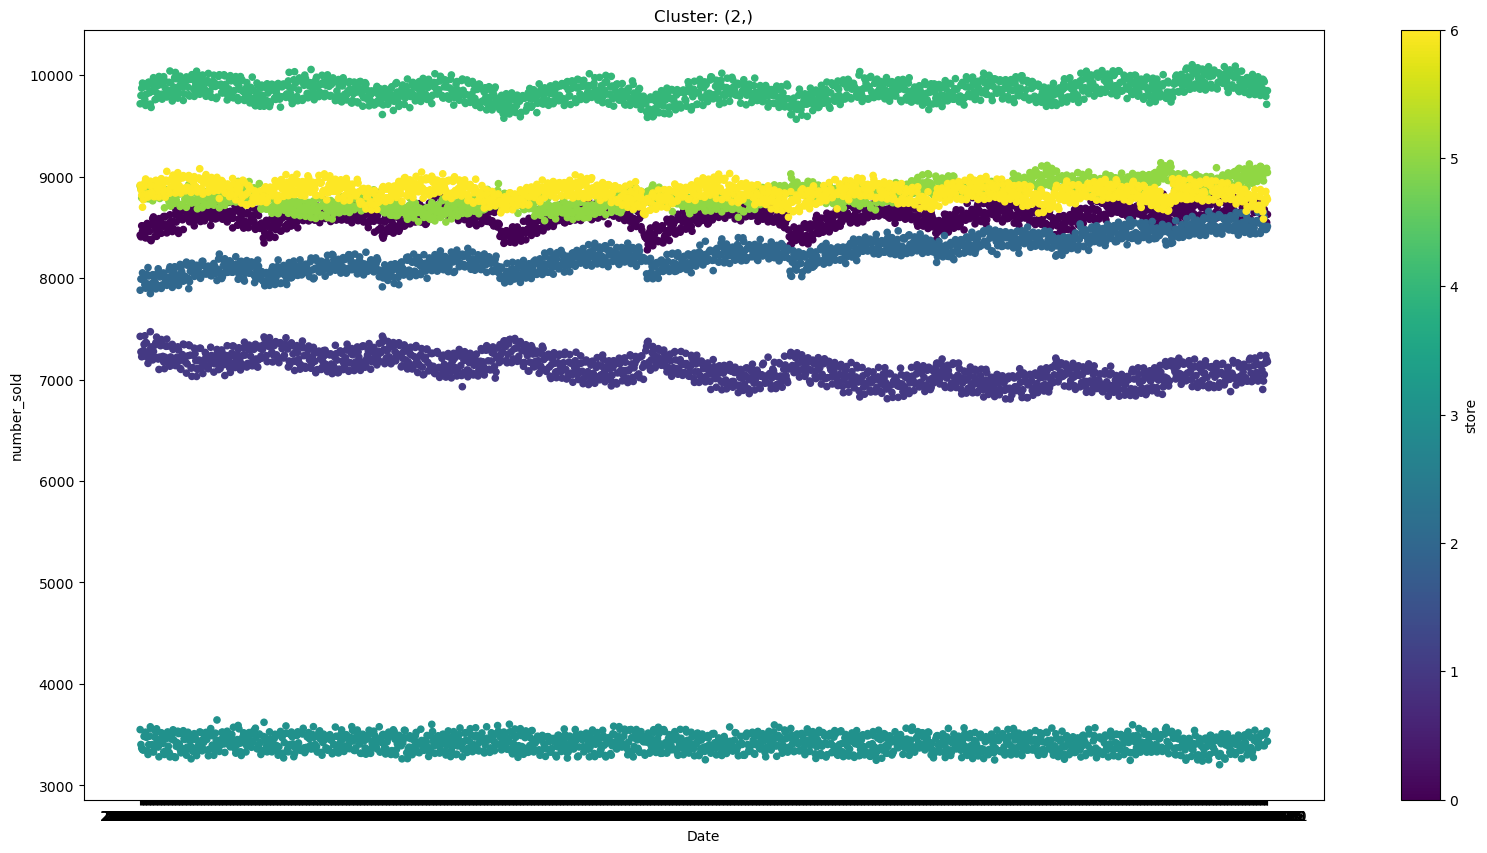

In [130]:
# let's plot the clusters and see which stores are in which cluster
# we will plot the cluster centroids in red
# we will plot the stores in blue

#lets group by cluster in the store_product_data_all_stores dataframe
store_product_data_all_stores_grouped_by_cluster = store_product_data_all_stores.groupby(['cluster'])
for name, group in store_product_data_all_stores_grouped_by_cluster:
    group.plot.scatter(x='Date', y='number_sold', c='store', title='Cluster: ' + str(name), colormap='viridis', figsize=(20, 10))

## Conclusion
From the above plots, it seems that the clusters have captured different trends in the time-series data. For example, 
1. cluster 1 appears to have the lowest frequency (yearly trends?)
2. cluster 2 appears to have a medium frequency (seasonal trends? - could be groups of months)
3. cluster 3 appears to have the highest frequency (monthly trends?)